In [19]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
#from matplotlib.patches import Ellipse
from math import sqrt
import wfdb

In [20]:
###### 主程式碼 poincare plot #######
def plot_poincare(rr):
    #Credit : BJORN (in Kaggle) 
    rr_n = rr[:-1] #第0個元素到倒數第2個元素
    rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n) #SD1的計算
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n) #SD2的計算

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')
    

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

In [21]:
###### 主程式碼 stepping #######
def stepping(rr):
    rr_n = rr[:-1] #第0個元素到倒數第2個元素
    rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素
    
    rrn_rrn1 = rr_n - rr_n1 # I1-I2, I2-I3, ...., I(n-2)-I(n-1), I(n-1) - I(n)
    Sum = 0 #sum_of_root_of_sum_of_2_square = 0 
    for i in range(len(rrn_rrn1)-1) : #假設資料長度是n，那麼兩兩相加
        #print("sqrt((rr {} - rr {} )**2 + (rr {} - rr {} )**2) = {}".format(i+1, i+2, i+2, i+3, sqrt(rrn_rrn1[i]**2 + rrn_rrn1[i+1]**2)))
        Sum += sqrt(rrn_rrn1[i]**2 + rrn_rrn1[i+1]**2)
    
    stepping = (Sum / (len(rr)-2) ) / (rr.sum() / len(rr))
    return stepping

In [22]:
def calculate_ratio(sequence):
    n = len(sequence)
    
    numerator_sum = 0
    for j in range(n-2):
        numerator_sum += np.sqrt((sequence[j] - sequence[j+1])**2 + (sequence[j+1] - sequence[j+2])**2)
    
    denominator_sum = np.sum(sequence)
    
    ratio = (numerator_sum / (n-2)) / (denominator_sum / n)
    
    return ratio

In [23]:
def dispersion(sequence):
    n = len(sequence)
    diff_squared = np.sum(np.square(np.diff(sequence)))
    absolute_diff = np.sum(np.abs(np.diff(sequence)))
    dispersion = np.sqrt((1/(2*(n-1))) * diff_squared - ((1/((n-1)*np.sqrt(2))) * absolute_diff)**2) / ((1/(2*(n-1))) * (-sequence[0] - sequence[n-1] + 2*np.sum(sequence[:-1])))
    return dispersion


In [39]:
######## 主程式 畫cluster ################
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_cluster(X, labels):
    """在上述程式碼中，我們使用 matplotlib.cm 模組的 rainbow 函數生成一個顏色映射，該映射根據分群數量平均分配顏色。使用 np.linspace 函數來指定顏色映射的範圍。接著，我們使用 colors[labels[index]] 選擇對應的顏色，並將其應用於散點圖的顏色。

    這種方法可以根據分群數量動態生成更多的顏色，因此可以適應更多的分群情況。您還可以根據需要選擇其他的預定義顏色映射，或者自訂一個顏色列表。
    """

    unique_labels = set(labels)

    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for index in range(len(labels)): 
        if labels[index] == -1:
            plt.scatter(X[index, 0], X[index, 1], color='b', marker='o')
        else:
            label_color = colors[labels[index]]
            plt.scatter(X[index, 0], X[index, 1], color=label_color, marker='o')

    plt.show()
    return 

In [47]:
from sklearn.cluster import DBSCAN
import numpy as np
def poincare_clustering_3(rr):
        
    rr_n = rr[:-1] #第0個元素到倒數第2個元素
    rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素
    X = np.concatenate((rr_n.reshape(len(rr_n),1),rr_n1.reshape(len(rr_n1),1)), axis=1)
    
    db = DBSCAN(eps=100, min_samples=10).fit(X)  #eps=0.3, min_samples=10
    labels = db.labels_
    
    print("labels = ",labels)
    print("type(labels)=",type(labels))
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("X = ", X)
    print("X.shape = ", X.shape)
    
    plt.figure()
    plot_cluster(X, labels)
    
    return n_clusters_, labels

清理完畢前的訊號品質 [0.97094395 0.97094395 0.97094395 ... 0.         0.         0.        ]
signal command : Excellent
[-0.02740211 -0.0074119  -0.02742169 ...  0.28904567  0.29403576
  0.28902585]
清理完畢後的訊號品質 [0.91052358 0.91052358 0.91052358 ... 0.         0.         0.        ]
Signal command :  Excellent
peak_locations =  [   143    252    359 ... 230076 230185 230298]
type(peak_locations) <class 'numpy.ndarray'>
peak_locations.size =  (2079,)
SD1: 119.022 ms
SD2: 134.856 ms
stepping =  0.08799288971424656
calculate_ratio = 0.08799288971424656
dispersion =  0.13224389545148837
labels =  [0 0 0 ... 0 0 0]
type(labels)= <class 'numpy.ndarray'>
Estimated number of clusters: 3
Estimated number of noise points: 34
X =  [[851.5625 835.9375]
 [835.9375 820.3125]
 [820.3125 804.6875]
 ...
 [921.875  851.5625]
 [851.5625 851.5625]
 [851.5625 882.8125]]
X.shape =  (2077, 2)


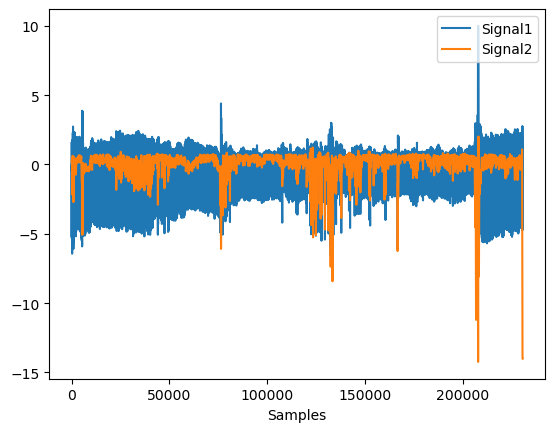

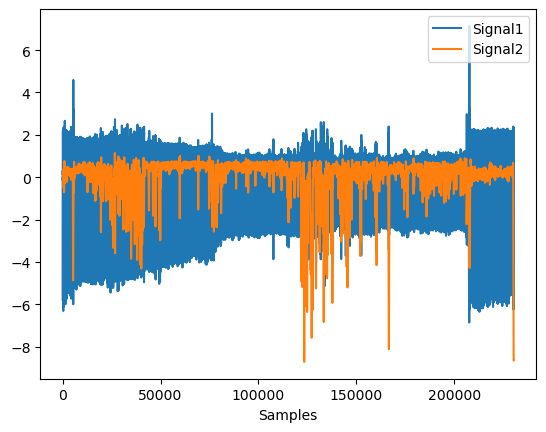

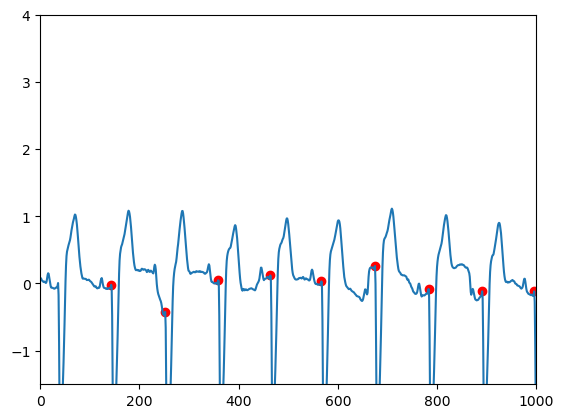

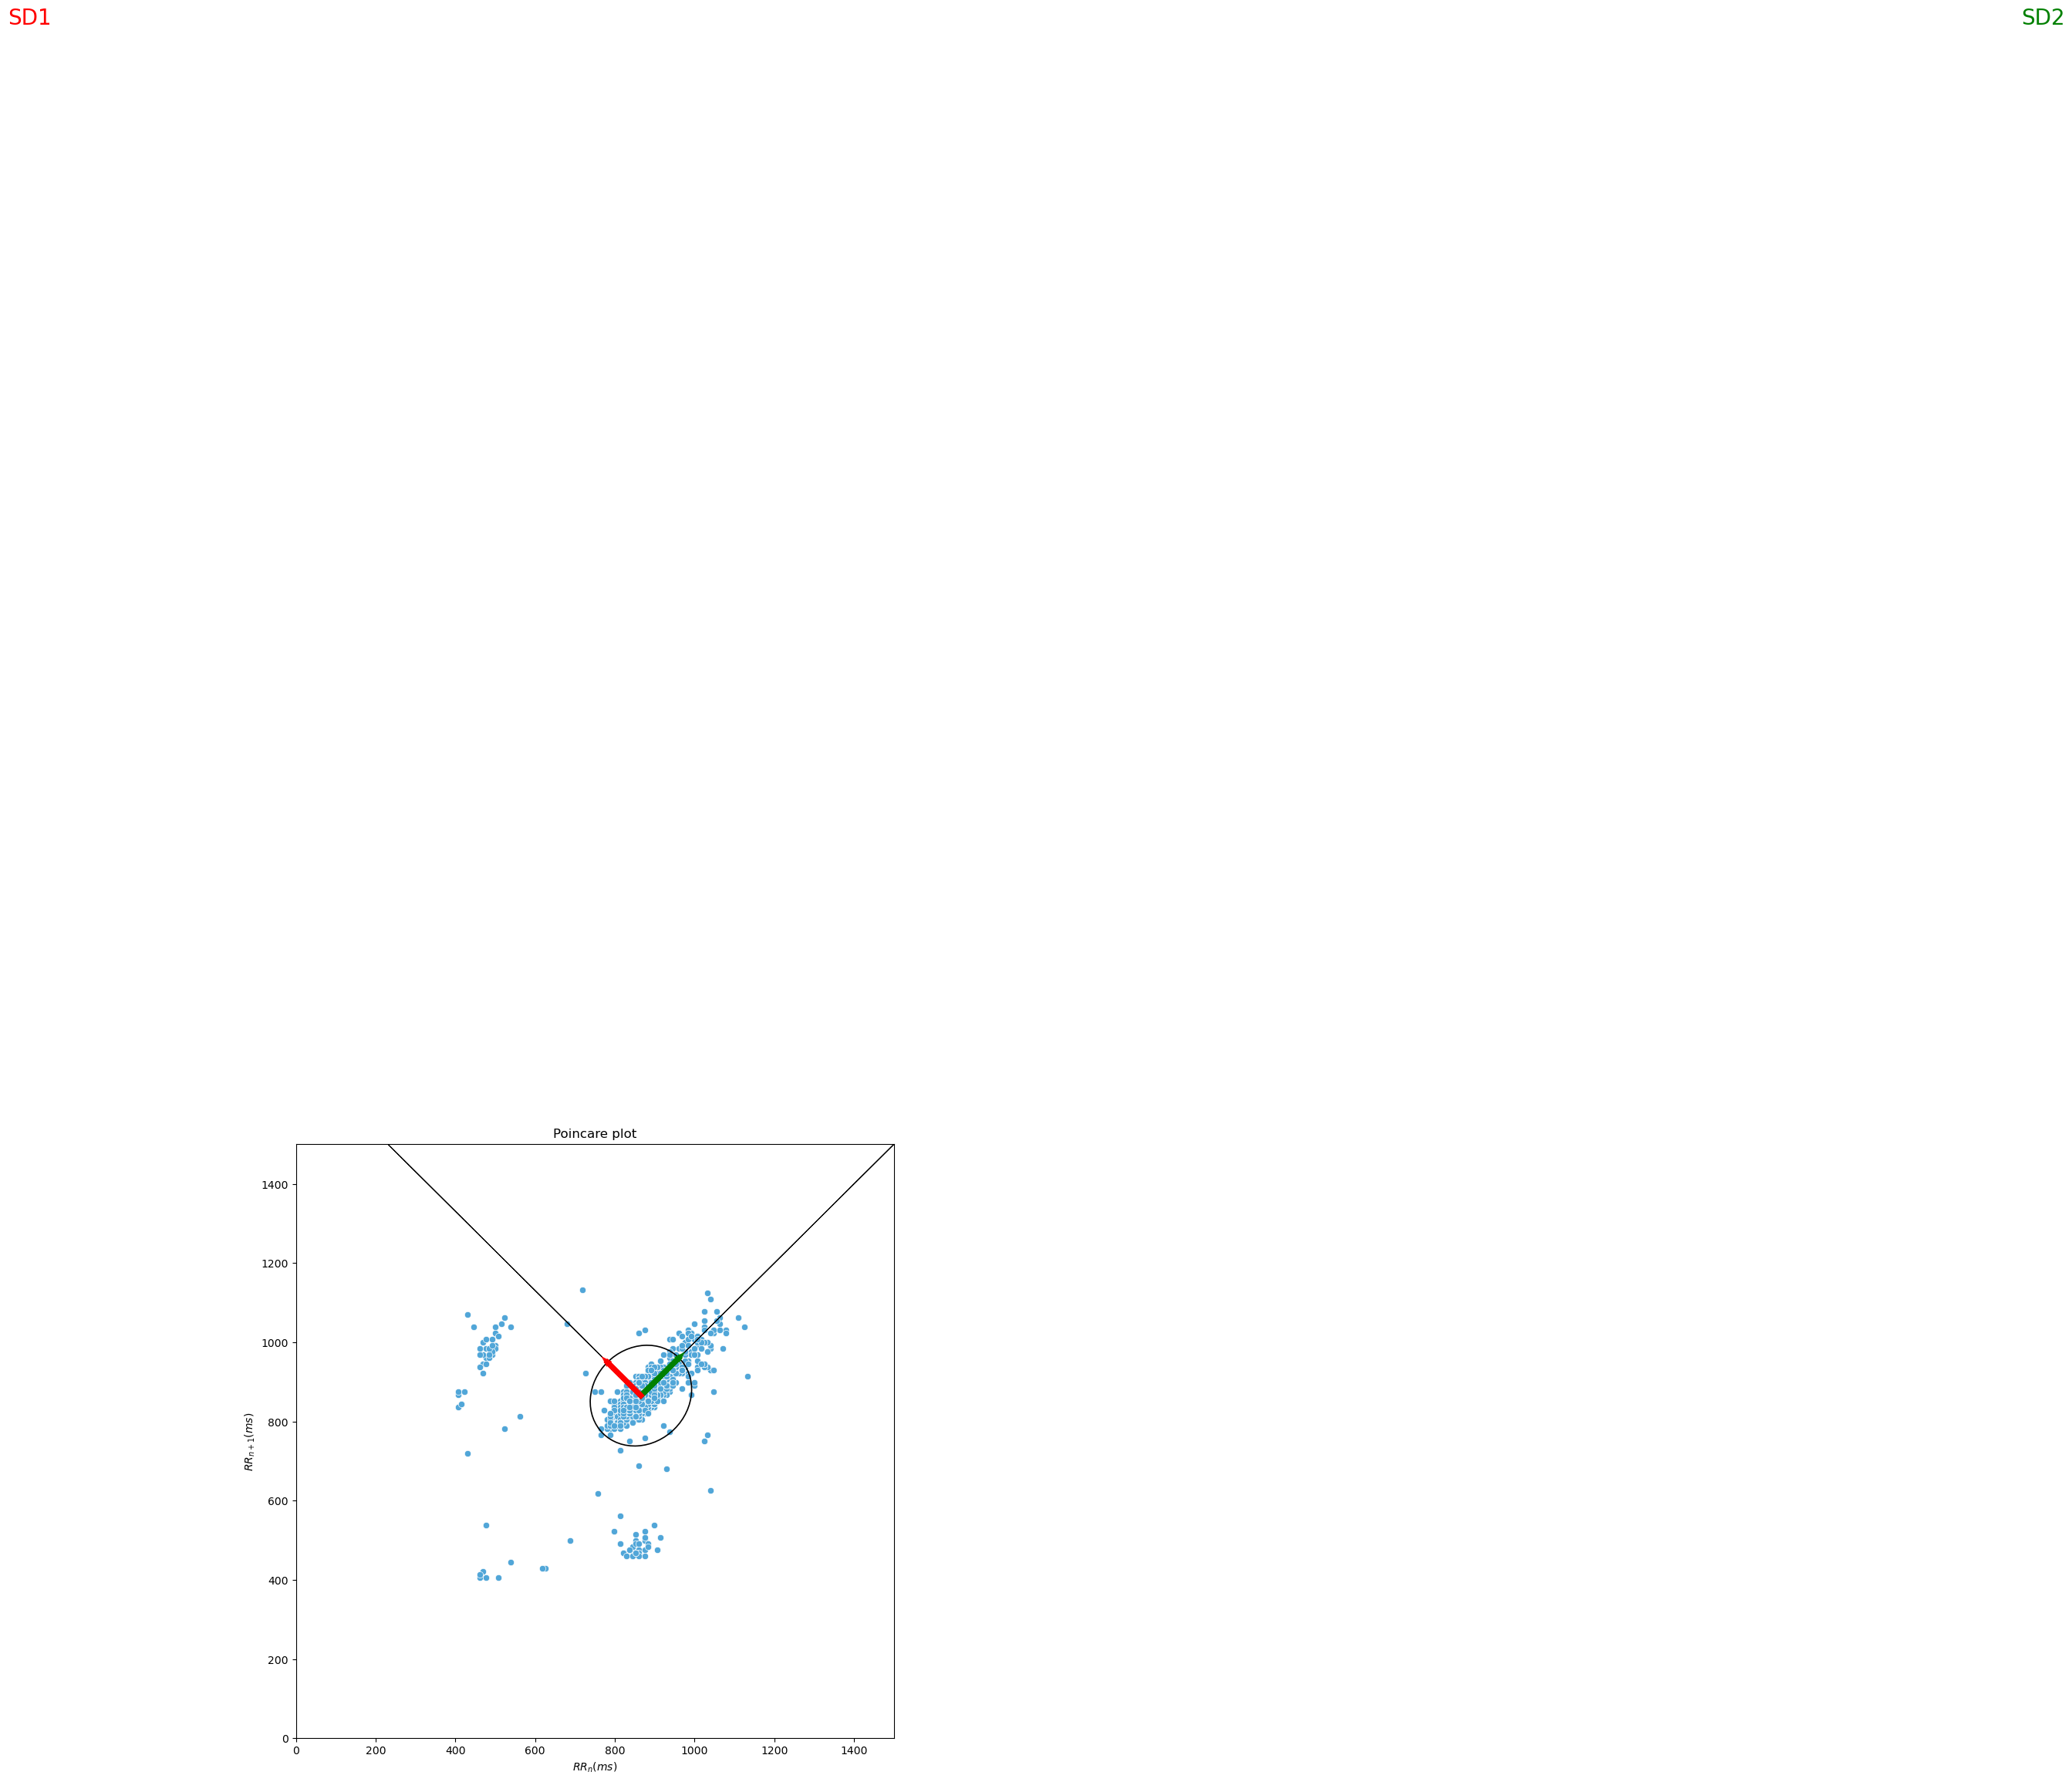

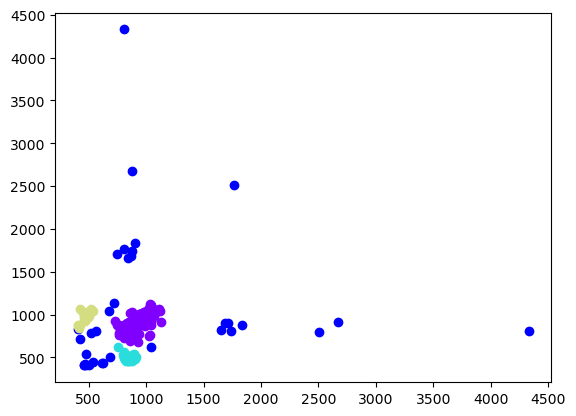

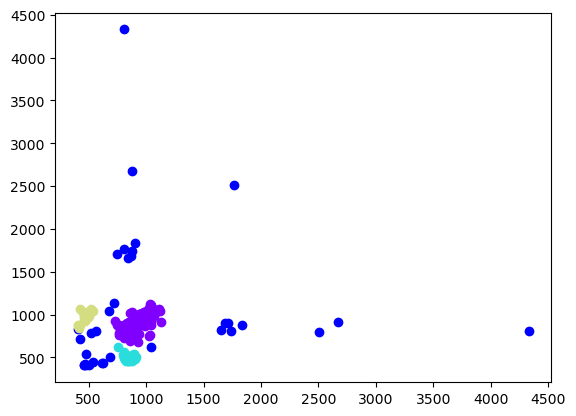

In [52]:
####主程式碼 1 ####

#请注意，这里使用正斜杠 (/) 而不是反斜杠 (\) 来表示文件路径的分隔符。这是因为在 Python 中，反斜杠被用作转义字符，因此需要使用两个反斜杠 (\\) 才能表示一个反斜杠。而使用正斜杠 (/) 是更常见和更便捷的方式，也是在跨平台的情况下推荐的方式。
record_path = os.path.abspath('D:/kaggle/paf-prediction-challenge-database-1.0.0/p19')
record = wfdb.rdrecord(record_path, channels=[0])  # 选择导联I(lead 1)（通道II是1）(簡言之:0=通道I，1=通道II)

quality1 = nk.ecg_quality(record.p_signal.reshape(-1), sampling_rate=128)
print("清理完畢前的訊號品質",quality1)
nk.signal_plot([record.p_signal.reshape(-1), quality1], standardize=True)
print("signal command :",nk.ecg_quality(record.p_signal.reshape(-1),
               sampling_rate=128,
               method="zhao2018",
               approach="fuzzy"))

# Detrending
detrended_signal = nk.signal_detrend(record.p_signal.reshape(-1), order="auto")
print(detrended_signal)

#注意!!!!!有些peak會抓不準，例如n20，從而導致偽陽性。
ecg_clean = nk.ecg_clean( detrended_signal, sampling_rate=128, method='neurokit') #記得先用reshape拉長 #因為record.p_signal是一個(38400(或230400), 1)的array，其實也就是兩層中括號，所以要拉成1維的。

quality2 = nk.ecg_quality(ecg_clean, sampling_rate=128)
print("清理完畢後的訊號品質",quality2)
nk.signal_plot([ecg_clean, quality2], standardize=True)
print("Signal command : ",nk.ecg_quality(ecg_clean,
               sampling_rate=128,
               method="zhao2018",
               approach="fuzzy"))




record_to_Series = pd.Series(ecg_clean)#detrended_clean_signal 
record_to_Series.size #沒有c結尾檔名的長度 : 230400 = 128hz * 60sec * 30min = 30分鐘的訊號 ； c結尾檔名的長度 : 38400  = 128hz * 60sec * 5 min = 5分鐘的訊號。
#奇數編號的記錄（例如 p15）包含遠離PAF的30分鐘ECG記錄；每對30分鐘記錄中的第二個（偶數編號ex p16）記錄包含在PAF發作之前的ECG記錄，可以通過檢查相同編號的延續記錄來驗證。

#diff_sig_ECG=np.diff(record_to_Series[0:record_to_Series.size]) #record_to_Series.size 訊號全長# 紀錄時長(eg. 30分鐘 or 5分鐘)*60秒*sampling rate

#distance=sampling rate*(30/60))= sampling rate*(一分鐘30下/60秒))，至於prominence=0.01是原作者試出來的
peaks_ECG, info = nk.ecg_peaks(record_to_Series, sampling_rate=128, method='neurokit2', correct_artifacts=False) #method='rodrigues2021'
peak_locations = info['ECG_R_Peaks']

print("peak_locations = ",peak_locations)
print("type(peak_locations)",type(peak_locations))
print("peak_locations.size = ",peak_locations.shape)


rr_ECG = np.diff(peak_locations)
corr_rr_ECG = rr_ECG*(1000/record.fs) #Sampling rate 是128HZ意思就是1秒sampling 128次，也就是說1秒的時間被分成了128等分，又1秒=1000毫秒，所以點跟點之間實際上差了1000/128毫秒。

plt.figure()
plt.plot(record_to_Series)
plt.scatter(peak_locations, record_to_Series[peak_locations], color="red")
plt.xlim(0, 1000)
plt.ylim(-1.5, 4)

import seaborn as sns
from matplotlib.patches import Ellipse
sd1_2, sd2_2 = plot_poincare(corr_rr_ECG) 
plt.xlim(0, 1500)
plt.ylim(0, 1500)
print("SD1: %.3f ms" % sd1_2)
print("SD2: %.3f ms" % sd2_2)
print("stepping = ", stepping(corr_rr_ECG))
print("calculate_ratio =", calculate_ratio(corr_rr_ECG))
print("dispersion = ", dispersion(corr_rr_ECG))

######以下的函數定義在後面##############

n_clusters_, labels = poincare_clustering_3(corr_rr_ECG)

#####這裡再利用plot_cluster函數重畫一次#########
rr = corr_rr_ECG
rr_n = rr[:-1] #第0個元素到倒數第2個元素
rr_n1 = rr[1:] #第1個元素到倒數第1(最後一個)個元素
X = np.concatenate((rr_n.reshape(len(rr_n),1),rr_n1.reshape(len(rr_n1),1)), axis=1)
plt.figure()
plot_cluster(X, labels)


In [37]:
labels.size

1798

In [38]:
len(labels)

1798